**<h3><u>Recommendaton System with Sentiment Analysis </u></h3>**

Preface: We try to build the Product Recommendation system using Amazon's product dataset and provide product recommendations according to certain input parameters. I also do the sentiment analysis on the dataset to filter products with positive feedback.

**<h4> Preparing the Dataset and Data extraction </h4>**

I am using the Amazon provided dataset from the below link

https://nijianmo.github.io/amazon/index.html

For this use case I use the Beauty products review data 5-core raw review data in the json zip format.



In [4]:
import pandas as pd
import numpy as np
import gzip

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

From the Amazon dataset page we can get the sample review and metadata data objects shown below

**Sample review:**

{

"image": ["https://images-na.ssl-images-amazon.com/images/I/71eG75FTJJL._SY88.jpg"], 

"overall": 5.0,

"vote": "2", 

"verified": True, 

"reviewTime": "01 1, 2018", 

"reviewerID": "AUI6WTTT0QZYS", 

"asin": "5120053084", 

"style": {
	"Size:": "Large", 
	"Color:": "Charcoal"
	}, 

"reviewerName": "Abbey", 

"reviewText": "I now have 4 of the 5 available colors of this shirt... ", 

"summary": "Comfy, flattering, discreet--highly recommended!", 

"unixReviewTime": 1514764800

}

where


*   reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
*   asin - ID of the product, e.g. 0000013714
*   reviewerName - name of the reviewer
*   vote - helpful votes of the review
*   style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
*   reviewText - text of the review
*   overall - rating of the product
*   summary - summary of the review
*   unixReviewTime - time of the review (unix time)
*   reviewTime - time of the review (raw)
*   image - images that users post after they have received the product


**Sample Metadata**

{
  
  "asin": "0000031852",
  
  "title": "Girls Ballet Tutu Zebra Hot Pink",
  
  "feature": ["Botiquecutie Trademark exclusive Brand",
              "Hot Pink Layered Zebra Print Tutu",
              "Fits girls up to a size 4T",
              "Hand wash / Line Dry",
              "Includes a Botiquecutie TM Exclusive hair flower bow"],
  
  "description": "This tutu is great for dress up play for your little ballerina. Botiquecute Trade Mark exclusive brand. Hot Pink Zebra print tutu.", 
  
  "price": 3.17,
  
  "imageURL": "http://ecx.images-amazon.com/images/I/51fAmVkTbyL._SY300_.jpg",
  
  "imageURLHighRes": "http://ecx.images-amazon.com/images/I/51fAmVkTbyL.jpg",
  
  "also_buy": ["B00JHONN1S", "B002BZX8Z6", "B00D2K1M3O", "0000031909"],
  
  "also_viewed": ["B002BZX8Z6", "B00JHONN1S", "B008F0SU0Y", "B00D23MC6W"],
  
  "salesRank": {"Toys & Games": 211836},
  
  "brand": "Coxlures",
  
  "categories": [["Sports & Outdoors", "Other Sports", "Dance"]]

}

where

*   asin - ID of the product, e.g. 0000031852
*   title - name of the product
*   feature - bullet-point format features of the product
*   description - description of the product
*   price - price in US dollars (at time of crawl)
*   imageURL - url of the product image
*   imageURL - url of the high resolution product image
*   related - related products (also bought, also viewed, bought together, buy after viewing)
*   salesRank - sales rank information
*   brand - brand name
*   categories - list of categories the product belongs to
*   tech1 - the first technical detail table of the product
*   tech2 - the second technical detail table of the product
*   similar - similar product table

In [3]:
### Import the All beauty products review data

##from google.colab import files
##uploaded = files.upload()

import io
review_df = pd.read_json('sample_data/All_Beauty.json.gz', orient='records', lines=True)

In [4]:
# changing columna name overall to Rating for sake of better understand 
review_df = review_df.rename(columns={'overall': 'Rating'})

print ("Total data:", str(review_df.shape))
review_df.head()

Total data: (371345, 12)


,Rating,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


In [5]:
## get the metadata dataframe

import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_meta = getDF('sample_data/meta_All_Beauty.json.gz')

In [6]:
df_meta.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [7]:
## merging the reviews and metadata dataframes we obtain the dataframe with all necessary information.

df_product_reviews = pd.merge(review_df,df_meta,on="asin",how="left")

In [8]:
df_product_reviews.head()

,Rating,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,...,feature,rank,also_view,details,main_cat,similar_item,date,price,imageURL,imageURLHighRes
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_product_reviews.shape

(387654, 30)

In [10]:
df_product_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387654 entries, 0 to 387653
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Rating           387654 non-null  int64 
 1   verified         387654 non-null  bool  
 2   reviewTime       387654 non-null  object
 3   reviewerID       387654 non-null  object
 4   asin             387654 non-null  object
 5   reviewerName     387615 non-null  object
 6   reviewText       387250 non-null  object
 7   summary          387442 non-null  object
 8   unixReviewTime   387654 non-null  int64 
 9   vote             54919 non-null   object
 10  style            132942 non-null  object
 11  image            8507 non-null    object
 12  category         382532 non-null  object
 13  tech1            382532 non-null  object
 14  description      382532 non-null  object
 15  fit              382532 non-null  object
 16  title            382532 non-null  object
 17  also_buy  

In [11]:
## check for all columsn with null values to evaluate the validity of the data and keep only data relevant to the whole modeling process.
df_product_reviews.isnull().sum()

Rating                  0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName           39
reviewText            404
summary               212
unixReviewTime          0
vote               332735
style              254712
image              379147
category             5122
tech1                5122
description          5122
fit                  5122
title                5122
also_buy             5122
tech2                5122
brand                5122
feature              5122
rank                 5122
also_view            5122
details              5122
main_cat             5122
similar_item         5122
date                 5122
price                5122
imageURL             5122
imageURLHighRes      5122
dtype: int64

In [12]:
## drop all null values of title from the dataframe to keep only relevant data. If title is null then the product is erroneous.
df_product_reviews_cond = df_product_reviews.dropna(subset=["title"])

In [13]:
## print the condense dataframe after removing null title rows
df_product_reviews_cond.info()

## you can see all the rows have the title in it so there is accuracy in the products being recommended.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382532 entries, 4833 to 387653
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Rating           382532 non-null  int64 
 1   verified         382532 non-null  bool  
 2   reviewTime       382532 non-null  object
 3   reviewerID       382532 non-null  object
 4   asin             382532 non-null  object
 5   reviewerName     382493 non-null  object
 6   reviewText       382132 non-null  object
 7   summary          382320 non-null  object
 8   unixReviewTime   382532 non-null  int64 
 9   vote             54741 non-null   object
 10  style            128104 non-null  object
 11  image            8410 non-null    object
 12  category         382532 non-null  object
 13  tech1            382532 non-null  object
 14  description      382532 non-null  object
 15  fit              382532 non-null  object
 16  title            382532 non-null  object
 17  also_bu

In [14]:
df_product_reviews_cond.isnull().sum()

Rating                  0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName           39
reviewText            400
summary               212
unixReviewTime          0
vote               327791
style              254428
image              374122
category                0
tech1                   0
description             0
fit                     0
title                   0
also_buy                0
tech2                   0
brand                   0
feature                 0
rank                    0
also_view               0
details                 0
main_cat                0
similar_item            0
date                    0
price                   0
imageURL                0
imageURLHighRes         0
dtype: int64

In [15]:
## fill votes with nan values with 0 to keep data clean
df_product_reviews_cond["vote"] = df_product_reviews_cond["vote"].fillna(0)

In [16]:
## drop style, image column which is not necessary for our predictions
df_product_reviews_cond_1 = df_product_reviews_cond.drop(["style","image"],axis=1)

In [17]:
## check again from null columns 
df_product_reviews_cond_1.isnull().sum()

Rating               0
verified             0
reviewTime           0
reviewerID           0
asin                 0
reviewerName        39
reviewText         400
summary            212
unixReviewTime       0
vote                 0
category             0
tech1                0
description          0
fit                  0
title                0
also_buy             0
tech2                0
brand                0
feature              0
rank                 0
also_view            0
details              0
main_cat             0
similar_item         0
date                 0
price                0
imageURL             0
imageURLHighRes      0
dtype: int64

In [18]:
## remove rows with null columns values
df_product_reviews_cond_2 = df_product_reviews_cond_1.dropna(subset=['reviewerName','reviewText','summary'])

In [19]:
df_product_reviews_cond_2.isnull().sum()
## we notice we have all the null values removed and cleaned the dataset to make sure all the columns contains all informative data.

Rating             0
verified           0
reviewTime         0
reviewerID         0
asin               0
reviewerName       0
reviewText         0
summary            0
unixReviewTime     0
vote               0
category           0
tech1              0
description        0
fit                0
title              0
also_buy           0
tech2              0
brand              0
feature            0
rank               0
also_view          0
details            0
main_cat           0
similar_item       0
date               0
price              0
imageURL           0
imageURLHighRes    0
dtype: int64

In [20]:
## since the summary and reviewtext provide the same review infomration as summary and detail, we concatenate them for simpler usage and
## and put it in a single column as full_review

df_product_reviews_cond_2["full_review"] = df_product_reviews_cond_2[['summary', 'reviewText']].apply(lambda x: " ".join(x), axis = 1)


In [21]:
## also remove the merged columns reviewText and summary
df_product_reviews_cond_3 = df_product_reviews_cond_2.drop(["reviewText","summary"],axis=1)

In [22]:
## we create new metrics to define if a product belongs to positive or negative set of items
## one such metric is to categorize products based on the ratings given, we categorize products rated less than 3 are bad and 3 or more as good.
df_product_reviews_cond_3["rating_class"] = df_product_reviews_cond_3["Rating"].apply(lambda r:'bad' if r <3 else 'good')
df_product_reviews_cond_3.head()


,Rating,verified,reviewTime,reviewerID,asin,reviewerName,unixReviewTime,vote,category,tech1,...,also_view,details,main_cat,similar_item,date,price,imageURL,imageURLHighRes,full_review,rating_class
4833,5,True,"03 10, 2016",A5TA1NJOC0PJ5,7414204790,Amazon Customer,1457568000,0,[],,...,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,Five Stars Excellent very good,good
4834,5,True,"09 1, 2015",A1TJICB7VLGQKL,7414204790,LH,1441065600,0,[],,...,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,Five Stars Great product,good
4835,5,True,"10 3, 2014",A80M2286B7STE,7414204790,dolly,1412294400,0,[],,...,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,Five Stars Magical,good
4836,5,True,"08 7, 2014",A2TM2MAA8IT34U,7414204790,Jack Warn,1407369600,0,[],,...,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,Five Stars Excellent!!!,good
4837,4,True,"06 14, 2014",AQGWT465GTEJG,7414204790,Chitralekha Tulal,1402704000,2,[],,...,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,Very pricey I do like the product a lot...I ha...,good


In [23]:
## Lets also create a popularity column based on the votes received and also based on whether the product is viewed along with other products.
##df_product_reviews_cond_3.info()

df_product_reviews_cond_3["vote"] = df_product_reviews_cond_3["vote"].apply(lambda x: int(str(x).replace(",","")))
max_vote = pd.to_numeric(df_product_reviews_cond_3["vote"]).max()
print(max_vote)
## create the "popularity_quotient_by_vote" column which is the current vote by the max votes received by a product. percentage value.
df_product_reviews_cond_3["popularity_quotient_by_vote"] = df_product_reviews_cond_3["vote"].apply(lambda x: 0.0 if x==0 else x/max_vote)

2721


In [24]:
## we also create a poluarity column based on the also_view count indicating whether the current product was also viewed along with other products
## higher the product view count in also_view higher the popularity rating.

also_view_list = {}
def createProductsAlsoViewedList():
  for k,v in df_product_reviews_cond_3.iterrows():
     for p in (v["also_view"]):
        if p in also_view_list:
          also_view_list[p] = also_view_list[p] + 1
        else:
          also_view_list[p] = 1

createProductsAlsoViewedList()

print(also_view_list)

df_product_reviews_cond_3["popularity_view_count"] = df_product_reviews_cond_3["asin"].apply(lambda x: also_view_list[x] if x in also_view_list else 0)



{'3254895630': 15, 'B007VL1D9S': 15, 'B00EH9A0RI': 15, 'B0773MBG4L': 31, 'B005631726': 31, 'B01A0S5326': 15, 'B076WS9D58': 15, 'B00F2RUKEW': 15, '8974525828': 15, 'B013BYNHX8': 15, 'B01MU7URIX': 15, 'B00KM2P7K4': 31, '0335336876': 15, 'B07CCGW11K': 15, 'B00L7RLWK2': 15, 'B01GR475CI': 15, 'B079STC2NH': 15, 'B013BYQHM6': 15, 'B00EH99VY6': 15, 'B010E1TWGW': 404, 'B072LVBJHH': 15, 'B00MV2MO8G': 15, 'B00OCJ5PUU': 15, 'B071ZZR11C': 256, 'B00027D6SE': 252, '4453451555': 15, 'B003TRV2V2': 15, 'B072J8FNKB': 15, 'B01MG4PZK0': 15, 'B01I45XWQQ': 15, 'B000T5MGF8': 15, 'B000UDC21C': 18, 'B019XHPUM8': 15, 'B01MRKR1G6': 392, 'B0064FFP96': 116, 'B00CE731B2': 15, 'B071SDS4ZM': 15, 'B07CVQHMG5': 488, 'B01M7TXCK3': 15, 'B01BPCAWK4': 1218, 'B0017SWIU4': 218, 'B07B7KDBZG': 258, 'B00G0EJYFW': 837, 'B00NR1YQK4': 122, 'B07FD34BM8': 1825, 'B00VMYKCL0': 268, 'B07DD5VQGP': 1621, 'B00NR1YQHM': 73, 'B017MOR60S': 1204, 'B07FSSYPPJ': 3517, 'B000YJ2SLG': 341, 'B001V9SXXU': 494, 'B00X6ZNWG0': 26, 'B01ES349CY': 2557, 'B

In [25]:
view_max = df_product_reviews_cond_3["popularity_view_count"].max()
print(view_max)

df_product_reviews_cond_3["popularity_quotient_by_view"] = df_product_reviews_cond_3["popularity_view_count"].apply(lambda x: x / view_max)

17041


In [26]:
## create a single popularity quotient column which is the average of popularity by vote and view count.

df_product_reviews_cond_3["popularity_quotient"] = (df_product_reviews_cond_3["popularity_quotient_by_vote"] + df_product_reviews_cond_3["popularity_quotient_by_view"] ) /2

## once the popularity quotient is created, drop the other two columns which are not needed anymore
df_product_reviews_cond_3.drop("popularity_quotient_by_vote", axis=1, inplace=True)
df_product_reviews_cond_3.drop("popularity_quotient_by_view", axis=1, inplace=True)

In [27]:
df_product_reviews_cond_3["popularity_quotient"]
max_popularity = df_product_reviews_cond_3["popularity_quotient"].max()

## create a poluarity class popular, least popular by checking if the popularity is above 70% of the max popularity.
## Note: this is a less accurate way to determining the value of a product, but this is just for sake of demonstration
## of data wragngling.

popularity_threshold = max_popularity / 0.7

df_product_reviews_cond_3["popularity_class"] = df_product_reviews_cond_3["popularity_quotient"].apply(lambda x: "popular" if x >= popularity_threshold else "least popular")

df_product_reviews_cond_3["popularity_class"]

4833      least popular
4834      least popular
4835      least popular
4836      least popular
4837      least popular
              ...      
387649    least popular
387650    least popular
387651    least popular
387652    least popular
387653    least popular
Name: popularity_class, Length: 381897, dtype: object

In [28]:
# Drop duplicate 'reviewName' and 'unixReviewTime'columns to preserve uniqueness.

df_product_reviews_cond_3 = df_product_reviews_cond_3.drop_duplicates(['asin','reviewerName', 'unixReviewTime'], keep = 'first')

In [29]:
df_product_reviews_cond_3.shape

(355638, 31)

Text(0, 0.5, 'Number of Reviews')

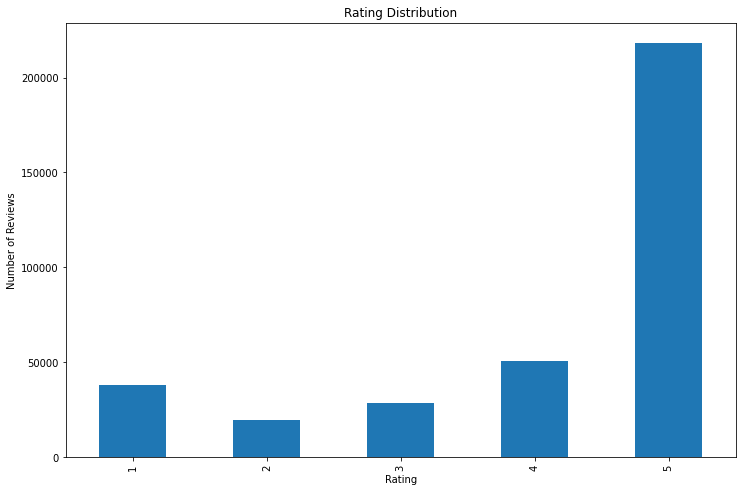

In [30]:
## Rating distribution Plot.

plt.figure(figsize=(12,8))
df_product_reviews_cond_3["Rating"].value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

## we can see from the plot below the distribution of ratings with 1,2,3,4,5

<h3> Text Preprocessing </h3>

Text cleaning is required to process raw text into a format which the manchines and machine learning algorithms can understand.

Firstly we need to conver the word embedding into a numerical representation and then we fit the representation into machine learning or deep learning algorithms.

The process involves the following steps.



1.   Normalizing text: This steps involes the removing of capitalization of characters which confuses the algoriths, hence text like "Books" becomes "books"
2.   Removing unicode characters: Unicode characters like punctuations, exclamations, emoji's and URLs can also confuse the algorithms, hence it is desirable to remove them
3. Removing stopwords: Stopwords are a set of comomonly used words in english. Words like “a”, “the”, “is”, “are” and etc do not provide much information about the text and hence can be removed without losing much value of the text.
4. Stemming and Lemmatization: Stemming groups the words by its root stem. eg: "pushing" "pushes" and "pushed" roots to the same word "push"
Lemmatization on the other hand groups words by definition and allows to differentiate between past, present and future tense. so "pushes" "push" are grouped into present tense "pushed" into past tense "pushing" into indefinite 

Let us code the implementation of the text pre processing.


In [31]:
import re, string, unicodedata
import nltk
from bs4 import BeautifulSoup

In [32]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [33]:
## normalize words to lower case
def normalize_text(words):
    clean_words = []

    for word in words:
       clean_words.append(word.lower())

    return clean_words

In [34]:
def remove_unicode_characters(words):
    clean_words = []

    for word in words:
       clean_word = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", word)
       clean_words.append(clean_word)

    return clean_words

In [35]:
def remove_nonascii_characters(words):
    clean_words = []
    for word in words:
        clean_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        clean_words.append(clean_word)
    return clean_words

In [36]:
import nltk.corpus
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

nltk.download('wordnet')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
def remove_stopwords(words):

   new_words = []

   for word in words:
      if word not in stop_words:
         new_words.append(word)
   
   return new_words


In [38]:
def stem_words(words):
    clean_words = []

    stemmer = PorterStemmer()
    for word in words:
       clean_word = stemmer.stem(word)
       clean_words.append(clean_word)

    
    return clean_words
       

In [39]:
def lemmatize_words(words):
    clean_words = []

    lemmatizer = WordNetLemmatizer()
    for word in words:
       clean_word = lemmatizer.lemmatize(word)
       clean_words.append(clean_word)

    
    return clean_words

In [40]:
def preprocess_text(text):
    clean_text = denoise_text(text)   
    words = nltk.word_tokenize(clean_text)
    words = normalize_text(words)
    words = remove_unicode_characters(words)
    words = remove_nonascii_characters(words)
    words = remove_stopwords(words)
    stems = stem_words(words)   
    lemmas = lemmatize_words(stems)
    return ' '.join(lemmas)

In [41]:
df_product_reviews_cond_3['clean_text'] = df_product_reviews_cond_3.iloc[:50000]['full_review'].map(lambda text: preprocess_text(text))


In [42]:
df_product_reviews_cond_3.head()

,Rating,verified,reviewTime,reviewerID,asin,reviewerName,unixReviewTime,vote,category,tech1,...,date,price,imageURL,imageURLHighRes,full_review,rating_class,popularity_view_count,popularity_quotient,popularity_class,clean_text
4833,5,True,"03 10, 2016",A5TA1NJOC0PJ5,7414204790,Amazon Customer,1457568000,0,[],,...,,$12.15,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,Five Stars Excellent very good,good,0,0.000000,least popular,five star excel good
4834,5,True,"09 1, 2015",A1TJICB7VLGQKL,7414204790,LH,1441065600,0,[],,...,,$12.15,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,Five Stars Great product,good,0,0.000000,least popular,five star great product
4835,5,True,"10 3, 2014",A80M2286B7STE,7414204790,dolly,1412294400,0,[],,...,,$12.15,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,Five Stars Magical,good,0,0.000000,least popular,five star magic
4836,5,True,"08 7, 2014",A2TM2MAA8IT34U,7414204790,Jack Warn,1407369600,0,[],,...,,$12.15,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,Five Stars Excellent!!!,good,0,0.000000,least popular,five star excel
4837,4,True,"06 14, 2014",AQGWT465GTEJG,7414204790,Chitralekha Tulal,1402704000,2,[],,...,,$12.15,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,Very pricey I do like the product a lot...I ha...,good,0,0.000368,least popular,pricey like product lot bought india cost 34...


<h3> Sentiment Analysis </h3>

We perform the Sentiment analysis on the clean data set. 
Here we use the Count Vecotorizer, TF-IDF and Hash Vectorizer techniques.




<h4> Perform Data cleaning </h4>

In [43]:
df_product_reviews_cond_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355638 entries, 4833 to 387653
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Rating                 355638 non-null  int64  
 1   verified               355638 non-null  bool   
 2   reviewTime             355638 non-null  object 
 3   reviewerID             355638 non-null  object 
 4   asin                   355638 non-null  object 
 5   reviewerName           355638 non-null  object 
 6   unixReviewTime         355638 non-null  int64  
 7   vote                   355638 non-null  int64  
 8   category               355638 non-null  object 
 9   tech1                  355638 non-null  object 
 10  description            355638 non-null  object 
 11  fit                    355638 non-null  object 
 12  title                  355638 non-null  object 
 13  also_buy               355638 non-null  object 
 14  tech2                  355638 non

In [44]:
## drop all unnecessary columns to keep the dataset light and relevant.

df = df_product_reviews_cond_3.drop(['Rating','verified','reviewTime','reviewerName','unixReviewTime','vote','category','tech1','description','fit','also_buy','tech2','brand','feature','rank','also_view','details','main_cat','similar_item','date','price','imageURL','imageURLHighRes','popularity_view_count','popularity_quotient'],axis=1)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355638 entries, 4833 to 387653
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   reviewerID        355638 non-null  object
 1   asin              355638 non-null  object
 2   title             355638 non-null  object
 3   full_review       355638 non-null  object
 4   rating_class      355638 non-null  object
 5   popularity_class  355638 non-null  object
 6   clean_text        50000 non-null   object
dtypes: object(7)
memory usage: 21.7+ MB


In [46]:
df.head()

,reviewerID,asin,title,full_review,rating_class,popularity_class,clean_text
4833,A5TA1NJOC0PJ5,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Five Stars Excellent very good,good,least popular,five star excel good
4834,A1TJICB7VLGQKL,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Five Stars Great product,good,least popular,five star great product
4835,A80M2286B7STE,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Five Stars Magical,good,least popular,five star magic
4836,A2TM2MAA8IT34U,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Five Stars Excellent!!!,good,least popular,five star excel
4837,AQGWT465GTEJG,7414204790,Lacto Calamine Skin Balance Oil control 120 ml...,Very pricey I do like the product a lot...I ha...,good,least popular,pricey like product lot bought india cost 34...


<h3> Natural Language Processing </h3>

**Feature Selection**

Machine learning algoriths takes numerical inputs, our dataset consists feature data in the form of texts and hence it is necessary that we perform a conversion of the texts into a numerical representation which our models can understand, ie, a list of numbers.

We will implement CounterVectorizer, TF-IDF techniques to accomplish the same.



**Perform the Data Preprocessing**



In [47]:
df['rating_class'] = df['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)
df['popularity_class'] = df['popularity_class'].apply(lambda x: 1 if x == 'popular' else 0)


In [48]:
# Splitting the Data Set into Train and Test Sets
X = df.iloc[:20000]['clean_text']
y = df.iloc[:20000]['rating_class']
Z = df.iloc[:20000]['popularity_class']

<h3> Split the Dataset into Train and Test sets </h3>
Let's split the dataset into Train and test sets to feed into the algoriths to check the performance of the model.

In [49]:
## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y,Z, test_size=0.25, random_state=42)

In [50]:
print(" Train test data info for X_train is Train set = %s Test set = %s" % (X_train.shape,X_test.shape))

 Train test data info for X_train is Train set = (15000,) Test set = (5000,)


<h3> Confusion Matrix Plot </h3>

Confusion Matirx Plot helps visualize the predictions our model makes with the true values.

In [51]:
import itertools

def plot_confusion_matrix(cm,class_names,normalize=False,title="Confusion Matrix",
                          cmap = plt.cm.ocean):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    #return plt
    plt.show()

<h3> Modeling </h3>
Choosing the right alogithm and to model the analysis is a vital part of making the recommendation system work accurately. For a supervised binary classification problem like this where we try to analyze the sentiment from the reviews text from the products data I chose the XGBOOST algorith. We need to note that the earlier data wragnlign techniques we already have applied to classify good and bad ratings and other classifications also help classify the products data into appropriate classes.

<h3> Feature Engineering </h3>

CountVectorizer Bag of Words:

Vectorizing is the process of converting texts into numerical representation or feature vectors. The bag of words strategy uses the counting of each occurance of word ignoring the relative position in a given document.

"CountVectorizer" implements both tokenization and occurrence counting in a single class.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer 

# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [53]:
# get the feature names from the bag of words vector
vocab = count_vect.get_feature_names()
# create a dataset for the count vector
pd.DataFrame(count_vect_train, columns = vocab).head()

,0041085107,007,01132009,016,02,04,05,06,060,0619d,...,zing,zip,zipcas,zipper,zit,zone,zoom,zum,zumbeliev,zummi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
## import all required libraries for modelling.

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier

<h3> XGBOOST with CountVecotrizer </h3>



In [63]:
# Instantiate the XGBClassifier.
model = XGBClassifier()
  
# Fitting classifier to the Training set
model.fit(count_vect_train, y_train)
    
# Predicting the Test set results
y_pred = model.predict(count_vect_test)
    
# Assign f1 score to a variable
score = f1_score(y_test, y_pred, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

f1 score: 0.8772451430949187


**Classification Report**

In [64]:
# Compute and print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.32      0.47       698
           1       0.90      0.99      0.94      4302

    accuracy                           0.90      5000
   macro avg       0.89      0.65      0.70      5000
weighted avg       0.90      0.90      0.88      5000



<h3> Plot Confusion Matrix </h3>

<Figure size 720x720 with 0 Axes>

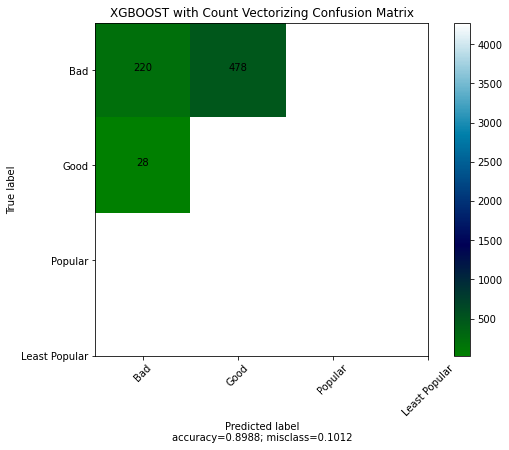

In [65]:
# Print confusion matrix for XGBOOST with countVectorizer
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, class_names=['Bad','Good','Popular','Least Popular'], normalize=False, 
                                 title =  'Confusion Matrix for XGBOOST with Count Vectorizing')

<H3>TF-IDF </H3>

TF-IDF score - Term Frequency, Inverse Document Frequency. This model puts the focus more on meaningful words. It weighs words by how rarely they occur in the document and discounts words that are too frequent and only add to the noise.


In [66]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

<h3>XGBoost with TF-IDF</h3>

In [ ]:
# Instantiate the XGBClassifier with TF-IDF vector
model = XGBClassifier()
  
# Fitting classifier to the Training set
model.fit(tfidf_vect_train, y_train)
    
# predict the Test set results
y_pred_tfidf_xgb = model.predict(tfidf_vect_test)
    
# Assign f1 score to a variable
score = f1_score(y_test, y_pred_tfidf_xgb, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

<h3> Classification Report</h3>

In [ ]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

<h3> Plot Confusion Matrix <h3>

In [ ]:
# Print confusion matrix for XGBOOST with TF-IDF vector
cm = confusion_matrix(y_test, y_pred_tfidf_xgb)
fig = plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=['Bad','Good','Popular','Least Popular'], normalize=False, 
                                 title =  'Confusion Matrix for XGBOOST with TF-IDF')

<h3> Recommendation System </h3>

We now focus on building the Recommendation system. I use different approaches to achieve the Product recommendation.

1. Recommendation based on Product populairty targetted to new customers.
2. Recommendation based on User's purchase history and ratings by other users using Model based Collaborative filtering.



Recommendation System. 1

Popularity based Recommendation system works for new customers who do not have any prior purchase history or not reviewed any products before. This approach uses ratings already made to products and recommeds products with highest ratings.




In [5]:
# %matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use("ggplot")

In [6]:
## read the dataset

ratings_df = pd.read_csv('sample_data/ratings_Beauty.csv')
ratings_df = ratings_df.dropna()
ratings_df.head()

,A39HTATAQ9V7YF,0205616461,5.0,1369699200
0,A3JM6GV9MNOF9X,0558925278,3.0,1.355443e+09
1,A1Z513UWSAAO0F,0558925278,5.0,1.404691e+09
2,A1WMRR494NWEWV,0733001998,4.0,1.382573e+09
3,A3IAAVS479H7M7,0737104473,1.0,1.274227e+09
4,AKJHHD5VEH7VG,0762451459,5.0,1.404518e+09


In [7]:
ratings_df.shape

(257357, 4)

In [8]:
ratings_df.columns

Index(['A39HTATAQ9V7YF', '0205616461', '5.0', '1369699200'], dtype='object')

In [9]:
ratings_df = ratings_df.rename(columns = {'A39HTATAQ9V7YF': 'user_id','0205616461':'product_id','5.0':'rating','1369699200':'time_stmap'})

In [10]:
ratings_df.info

<bound method DataFrame.info of                user_id  product_id  rating    time_stmap
0       A3JM6GV9MNOF9X  0558925278     3.0  1.355443e+09
1       A1Z513UWSAAO0F  0558925278     5.0  1.404691e+09
2       A1WMRR494NWEWV  0733001998     4.0  1.382573e+09
3       A3IAAVS479H7M7  0737104473     1.0  1.274227e+09
4        AKJHHD5VEH7VG  0762451459     5.0  1.404518e+09
...                ...         ...     ...           ...
257352  A1F10XRZR6ZAY0  B000G666HE     5.0  1.381709e+09
257353  A28V0T5CIPXSZI  B000G666HE     5.0  1.392768e+09
257354  A3BRIJQD0CA90K  B000G666HE     4.0  1.381190e+09
257355  A33WFA8G38QK79  B000G666HE     5.0  1.362096e+09
257356   A9QJ56LDJGIVV  B000G666HE     1.0  1.198541e+09

[257357 rows x 4 columns]>

In [11]:
popular_products_df = pd.DataFrame(ratings_df.groupby('product_id')['rating'].count())
most_popular_products = popular_products_df.sort_values('rating', ascending=False)
most_popular_products.head(10)

,rating
product_id,
B0009V1YR8,2869
B0000YUXI0,2143
B000FS05VG,1589
B000142FVW,1558
B00021DVCQ,1051
B0002JKPA4,1046
B000ASDGK8,888
B00016XJ4M,845
B0009FHJRS,828


<Figure size 36000x18000 with 0 Axes>

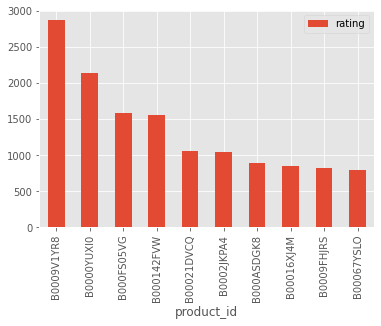

In [17]:
## plot the most popular products in the graph.
plt.figure(figsize=(500, 250))
most_popular_products.head(10).plot(kind ='bar')

2. <h3> Model based Collaborative Filetring </h3>
Recommend products based on the ratins provided by other users and products similar to the one purchased by the customer. 

Model based filtering identifies patterns based on the inputs from the other users.


Utility Matrix: Utility matrix is a matrix of all possibilities of user ratings for a product. The utility matrix is a sparse reprsentation as none of the user would buy all the products in the list.

In [18]:
# lets take a sub set of the ratins dataframe to keep data limited for computational purposes.

ratings_df_cond = ratings_df.head(10000)

In [19]:
ratings_df_cond.shape

(10000, 4)

In [20]:
ratings_utility_matrix = ratings_df_cond.pivot_table(values='rating', index='user_id', columns='product_id', fill_value=0)
ratings_utility_matrix.head()

product_id,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,130414674X,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
user_id,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Trasnpose the Matrix**

In [22]:
X_trans = ratings_utility_matrix.T
X_trans.head()

user_id,A00205921JHJK5X9LNP42,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A07410232KYRFR25CIUGJ,A082796624UNM47DSAI6K,A0864963DOAY7LXGS5I6,...,AZW1HXXYAC15B,AZWRTJPN7NXT,AZWTXHXZXFAYP,AZYQEFB9Y5N22,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
product_id,,,,,,,,,,,,,,,,,,,,,
0558925278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0733001998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0737104473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0762451459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1304139212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_trans.shape

(885, 9697)

<h3> Decompose the Matrix </h3>

In [24]:
import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X_trans
decomposed_matrix.shape

(885, 10)

<h3> Correlation Matrix </h3>

In [25]:
## create correcation matrix from the decomposed matrix. this basically creates a matrix which establishes 
## the correlation between each of the products with other products.
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(885, 885)

In [28]:
print(decomposed_matrix)

[[ 2.30181345e-14 -1.75322252e-13 -2.11032380e-13 ...  4.38978842e-12
  -8.36741506e-12 -4.24106148e-14]
 [ 1.03530036e-16 -4.06280002e-15  1.53158808e-15 ... -4.89810497e-14
   3.44317744e-14 -1.68815590e-13]
 [ 2.00152875e-23 -5.85329618e-23  1.55907104e-23 ... -1.38153215e-21
   5.94031663e-22 -1.59095116e-20]
 ...
 [ 3.27184309e-06  2.27947983e-01 -1.04077291e-02 ... -3.78219566e-03
   4.08714109e-05 -4.91997978e-02]
 [ 7.71984835e-07  8.24137325e-04 -6.44875776e-05 ...  1.44017209e-04
  -6.45046277e-04 -4.77836728e-03]
 [ 5.14259435e-04  4.21215259e-01  3.55682403e-01 ... -4.91405663e-03
  -8.86190624e-02  6.31456632e-01]]



**Lets pick a random product from the dataset and try to work around that to find recommendations which are similar to the product.**



In [30]:
X.index[50]

'1412759676'

Get the index of the product id '1412759676'

In [31]:
i = "1412759676"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

50

<h3> Correlation of all the itmes from the matrix for this product id with all the users who have brought the same product </h3>

In [32]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(885,)

Recommend the top 10 highly correlated products to this particular Product ID.

In [33]:
recommand_products = list(X.index[correlation_product_ID > 0.90])

# Remove the product already used.
recommand_products.remove(i) 

recommand_products[0:9]

['1304139212',
 '1304139220',
 '130414643X',
 '1304146537',
 '130414674X',
 '1304168522',
 '1304174778',
 '1304174867',
 '1304174905']

These products represet the top 10 highly correlated products similar to the product with id '1412759676' based on the high correlation coefficent of greater than 0.90.